<a href="https://colab.research.google.com/github/pra1608/quality-Prediction-in-mining/blob/main/LSTM_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [75]:
df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/cleaned.pkl')



In [76]:
df = df.set_index(['datetime'])

In [77]:
df

,date,year,month,day,hour,minute,second,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-30 00:00:00,2017-03-30 00:00:00,2017,3,30,0,0,0,59.54,9.56,1908.12,533.542,401.045,9.60323,1.72484,199.558,195.234,201.326,295.096,306.400,250.002,250.767,855.130039,821.072299,878.547321,459.554,592.059,551.010,522.392,66.36,1.69
2017-03-30 00:00:20,2017-03-30 00:00:00,2017,3,30,0,0,20,59.54,9.56,1894.65,533.922,400.325,9.60346,1.72505,199.561,194.898,201.855,295.096,306.400,250.000,250.757,855.129135,821.090690,878.661714,441.190,592.457,559.622,512.828,66.36,1.69
2017-03-30 00:00:40,2017-03-30 00:00:00,2017,3,30,0,0,40,59.54,9.56,1895.93,533.001,398.791,9.60369,1.72526,199.937,196.684,201.051,295.096,306.400,249.668,252.629,855.128230,821.109080,878.776107,453.158,590.323,548.417,501.807,66.36,1.69
2017-03-30 00:01:00,2017-03-30 00:00:00,2017,3,30,0,1,0,59.54,9.56,1876.59,534.324,396.910,9.60392,1.72547,199.819,196.919,199.288,295.096,306.400,250.138,250.395,855.127326,821.127471,878.890500,462.899,584.949,558.436,503.901,66.36,1.69
2017-03-30 00:01:20,2017-03-30 00:00:00,2017,3,30,0,1,20,59.54,9.56,1859.19,534.741,395.766,9.60415,1.72568,199.796,196.837,198.554,295.096,306.400,250.456,249.246,855.126421,821.145861,879.004893,476.801,581.155,560.810,507.434,66.36,1.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 23:58:20,2017-09-09 23:00:00,2017,9,9,23,58,20,49.75,23.20,2710.94,441.052,386.570,9.62129,1.65365,302.344,298.786,299.163,299.920,299.623,346.794,313.695,392.160000,430.702000,872.008000,418.725,497.548,446.357,416.892,64.27,1.71
2017-09-09 23:58:40,2017-09-09 23:00:00,2017,9,9,23,58,40,49.75,23.20,2692.01,473.436,384.939,9.62063,1.65352,303.013,301.879,299.487,299.710,300.465,330.023,236.700,401.505000,404.616000,864.409000,418.377,506.398,372.995,426.337,64.27,1.71
2017-09-09 23:59:00,2017-09-09 23:00:00,2017,9,9,23,59,0,49.75,23.20,2692.20,500.488,383.496,9.61874,1.65338,303.662,307.397,299.487,299.927,299.707,329.590,225.879,408.899000,399.316000,867.598000,419.531,503.414,336.035,433.130,64.27,1.71


##Data Preprocessing
Here we are picking 708480 data points for training. Observation is recorded every ~20 sec, that means 3 times per minute. 

We are tracking data from past 60 timestamps (60/3=20 minute). This data will be used to predict the temperature after 3 timestamps (3/3=1 minute).

Since every feature has values with varying ranges, we do normalization to confine feature values to a range of [0, 1] before training a neural network. We do this by subtracting the mean and dividing by the standard deviation of each feature.

80 % of the data will be used to train the model, i.e. 566784 rows. split_fraction can be changed to alter this percentage.


In [79]:
split_fraction = 0.9
train_split = int(split_fraction * int(df.shape[0]))
step = 3

past = 60
future = 3
learning_rate = 0.001
batch_size = 256
epochs = 3

In [109]:
train_split

637632

In [80]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [81]:
df.columns

Index(['date', 'year', 'month', 'day', 'hour', 'minute', 'second',
       '% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')

In [82]:
df.columns[7:-2].tolist()

['% Iron Feed',
 '% Silica Feed',
 'Starch Flow',
 'Amina Flow',
 'Ore Pulp Flow',
 'Ore Pulp pH',
 'Ore Pulp Density',
 'Flotation Column 01 Air Flow',
 'Flotation Column 02 Air Flow',
 'Flotation Column 03 Air Flow',
 'Flotation Column 04 Air Flow',
 'Flotation Column 05 Air Flow',
 'Flotation Column 06 Air Flow',
 'Flotation Column 07 Air Flow',
 'Flotation Column 01 Level',
 'Flotation Column 02 Level',
 'Flotation Column 03 Level',
 'Flotation Column 04 Level',
 'Flotation Column 05 Level',
 'Flotation Column 06 Level',
 'Flotation Column 07 Level']

In [83]:
selected_features = df.columns[7:].tolist()
features = df[selected_features]
features.head()



,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
datetime,,,,,,,,,,,,,,,,,,,,,,,
2017-03-30 00:00:00,59.54,9.56,1908.12,533.542,401.045,9.60323,1.72484,199.558,195.234,201.326,295.096,306.4,250.002,250.767,855.130039,821.072299,878.547321,459.554,592.059,551.010,522.392,66.36,1.69
2017-03-30 00:00:20,59.54,9.56,1894.65,533.922,400.325,9.60346,1.72505,199.561,194.898,201.855,295.096,306.4,250.000,250.757,855.129135,821.090690,878.661714,441.190,592.457,559.622,512.828,66.36,1.69
2017-03-30 00:00:40,59.54,9.56,1895.93,533.001,398.791,9.60369,1.72526,199.937,196.684,201.051,295.096,306.4,249.668,252.629,855.128230,821.109080,878.776107,453.158,590.323,548.417,501.807,66.36,1.69
2017-03-30 00:01:00,59.54,9.56,1876.59,534.324,396.910,9.60392,1.72547,199.819,196.919,199.288,295.096,306.4,250.138,250.395,855.127326,821.127471,878.890500,462.899,584.949,558.436,503.901,66.36,1.69
2017-03-30 00:01:20,59.54,9.56,1859.19,534.741,395.766,9.60415,1.72568,199.796,196.837,198.554,295.096,306.4,250.456,249.246,855.126421,821.145861,879.004893,476.801,581.155,560.810,507.434,66.36,1.69


In [84]:
features

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
datetime,,,,,,,,,,,,,,,,,,,,,,,
2017-03-30 00:00:00,59.54,9.56,1908.12,533.542,401.045,9.60323,1.72484,199.558,195.234,201.326,295.096,306.400,250.002,250.767,855.130039,821.072299,878.547321,459.554,592.059,551.010,522.392,66.36,1.69
2017-03-30 00:00:20,59.54,9.56,1894.65,533.922,400.325,9.60346,1.72505,199.561,194.898,201.855,295.096,306.400,250.000,250.757,855.129135,821.090690,878.661714,441.190,592.457,559.622,512.828,66.36,1.69
2017-03-30 00:00:40,59.54,9.56,1895.93,533.001,398.791,9.60369,1.72526,199.937,196.684,201.051,295.096,306.400,249.668,252.629,855.128230,821.109080,878.776107,453.158,590.323,548.417,501.807,66.36,1.69
2017-03-30 00:01:00,59.54,9.56,1876.59,534.324,396.910,9.60392,1.72547,199.819,196.919,199.288,295.096,306.400,250.138,250.395,855.127326,821.127471,878.890500,462.899,584.949,558.436,503.901,66.36,1.69
2017-03-30 00:01:20,59.54,9.56,1859.19,534.741,395.766,9.60415,1.72568,199.796,196.837,198.554,295.096,306.400,250.456,249.246,855.126421,821.145861,879.004893,476.801,581.155,560.810,507.434,66.36,1.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 23:58:20,49.75,23.20,2710.94,441.052,386.570,9.62129,1.65365,302.344,298.786,299.163,299.920,299.623,346.794,313.695,392.160000,430.702000,872.008000,418.725,497.548,446.357,416.892,64.27,1.71
2017-09-09 23:58:40,49.75,23.20,2692.01,473.436,384.939,9.62063,1.65352,303.013,301.879,299.487,299.710,300.465,330.023,236.700,401.505000,404.616000,864.409000,418.377,506.398,372.995,426.337,64.27,1.71
2017-09-09 23:59:00,49.75,23.20,2692.20,500.488,383.496,9.61874,1.65338,303.662,307.397,299.487,299.927,299.707,329.590,225.879,408.899000,399.316000,867.598000,419.531,503.414,336.035,433.130,64.27,1.71


In [85]:
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.606934,-0.746862,-0.759423,0.503416,0.325732,-0.657643,0.654847,-2.707552,-2.678984,-2.758765,-1.855498,1.969853,-1.477842,-1.483190,2.486672,2.282502,2.230165,0.435447,2.000654,1.415304,1.215023,1.171458,-0.542869
1,0.606934,-0.746862,-0.770427,0.507582,0.243168,-0.656976,0.657862,-2.707451,-2.690076,-2.740409,-1.855498,1.969853,-1.477914,-1.483556,2.486665,2.282643,2.230914,0.229363,2.005405,1.512699,1.101338,1.171458,-0.542869
2,0.606934,-0.746862,-0.769382,0.497485,0.067260,-0.656308,0.660877,-2.694779,-2.631116,-2.768308,-1.855498,1.969853,-1.489933,-1.415102,2.486658,2.282784,2.231663,0.363670,1.979929,1.385979,0.970333,1.171458,-0.542869
3,0.606934,-0.746862,-0.785181,0.511989,-0.148439,-0.655640,0.663891,-2.698755,-2.623358,-2.829483,-1.855498,1.969853,-1.472919,-1.496793,2.486651,2.282925,2.232412,0.472985,1.915772,1.499286,0.995224,1.171458,-0.542869
4,0.606934,-0.746862,-0.799396,0.516561,-0.279624,-0.654972,0.666906,-2.699531,-2.626065,-2.854952,-1.855498,1.969853,-1.461407,-1.538809,2.486644,2.283066,2.233161,0.628995,1.870477,1.526134,1.037220,1.171458,-0.542869


In [86]:
X1 = features[features.columns.tolist()[0:21]]
Y1 = features[features.columns.tolist()[22]]


In [87]:
X1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.606934,-0.746862,-0.759423,0.503416,0.325732,-0.657643,0.654847,-2.707552,-2.678984,-2.758765,-1.855498,1.969853,-1.477842,-1.483190,2.486672,2.282502,2.230165,0.435447,2.000654,1.415304,1.215023
1,0.606934,-0.746862,-0.770427,0.507582,0.243168,-0.656976,0.657862,-2.707451,-2.690076,-2.740409,-1.855498,1.969853,-1.477914,-1.483556,2.486665,2.282643,2.230914,0.229363,2.005405,1.512699,1.101338
2,0.606934,-0.746862,-0.769382,0.497485,0.067260,-0.656308,0.660877,-2.694779,-2.631116,-2.768308,-1.855498,1.969853,-1.489933,-1.415102,2.486658,2.282784,2.231663,0.363670,1.979929,1.385979,0.970333
3,0.606934,-0.746862,-0.785181,0.511989,-0.148439,-0.655640,0.663891,-2.698755,-2.623358,-2.829483,-1.855498,1.969853,-1.472919,-1.496793,2.486651,2.282925,2.232412,0.472985,1.915772,1.499286,0.995224
4,0.606934,-0.746862,-0.799396,0.516561,-0.279624,-0.654972,0.666906,-2.699531,-2.626065,-2.854952,-1.855498,1.969853,-1.461407,-1.538809,2.486644,2.283066,2.233161,0.628995,1.870477,1.526134,1.037220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708475,-1.232519,1.220842,-0.103577,-0.510561,-1.334154,-0.605215,-0.367091,0.756570,0.739526,0.636125,0.088179,-0.028997,2.026055,0.817924,-0.997085,-0.713102,2.187347,-0.022743,0.872339,0.231758,-0.039037
708476,-1.232519,1.220842,-0.119042,-0.155532,-1.521185,-0.607131,-0.368958,0.779117,0.841634,0.647368,0.003566,0.219347,1.418940,-1.997584,-0.926766,-0.913279,2.137591,-0.026648,0.977994,-0.597911,0.073234
708477,-1.232519,1.220842,-0.118886,0.141042,-1.686658,-0.612618,-0.370967,0.800990,1.023797,0.647368,0.091000,-0.004222,1.403265,-2.393280,-0.871128,-0.953950,2.158472,-0.013698,0.942370,-1.015900,0.153982
708478,-1.232519,1.220842,-1.367218,0.043032,-1.516942,-0.618075,-0.372977,0.763513,0.844275,0.597331,-0.132620,-0.266134,2.194712,0.613878,-0.899662,-0.435849,2.217355,-0.150967,0.929082,-0.961514,0.163919


In [88]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
pd.pandas.set_option('display.max_columns', None)
feature_sel_model = SelectFromModel(Lasso(alpha=0.005, random_state=0)) # remember to set the seed, the random state in this function
feature_sel_model.fit(X1, Y1)

SelectFromModel(estimator=Lasso(alpha=0.005, copy_X=True, fit_intercept=True,
                                max_iter=1000, normalize=False, positive=False,
                                precompute=False, random_state=0,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [89]:
selected_feat = X1.columns[(feature_sel_model.get_support())]


In [90]:
checklist = selected_feat.tolist()

In [91]:
checklist

[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 20]

In [94]:
features = features.loc[:,[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 18, 20,21,22]]

In [95]:
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [96]:
train_data

,0,1,2,3,4,5,6,7,9,10,11,12,13,16,17,18,20,21,22
0,0.606934,-0.746862,-0.759423,0.503416,0.325732,-0.657643,0.654847,-2.707552,-2.758765,-1.855498,1.969853,-1.477842,-1.483190,2.230165,0.435447,2.000654,1.215023,1.171458,-0.542869
1,0.606934,-0.746862,-0.770427,0.507582,0.243168,-0.656976,0.657862,-2.707451,-2.740409,-1.855498,1.969853,-1.477914,-1.483556,2.230914,0.229363,2.005405,1.101338,1.171458,-0.542869
2,0.606934,-0.746862,-0.769382,0.497485,0.067260,-0.656308,0.660877,-2.694779,-2.768308,-1.855498,1.969853,-1.489933,-1.415102,2.231663,0.363670,1.979929,0.970333,1.171458,-0.542869
3,0.606934,-0.746862,-0.785181,0.511989,-0.148439,-0.655640,0.663891,-2.698755,-2.829483,-1.855498,1.969853,-1.472919,-1.496793,2.232412,0.472985,1.915772,0.995224,1.171458,-0.542869
4,0.606934,-0.746862,-0.799396,0.516561,-0.279624,-0.654972,0.666906,-2.699531,-2.854952,-1.855498,1.969853,-1.461407,-1.538809,2.233161,0.628995,1.870477,1.037220,1.171458,-0.542869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637627,0.798583,-1.127707,0.418170,-1.605390,-2.270875,-2.489611,0.785622,0.689907,0.708370,-0.351808,-0.911476,0.289673,0.402847,-0.226173,1.367155,0.909491,0.403213,0.500205,-0.082755
637628,0.798583,-1.127707,0.430522,-1.621101,-2.272190,-2.489611,0.787058,0.677504,0.726275,0.034188,-0.868119,0.431035,0.319327,-0.281848,1.434769,0.872017,0.471384,0.500205,-0.082755
637629,0.798583,-1.127707,0.465095,-1.643246,-2.273505,-2.489611,0.788493,0.655362,0.756637,0.799330,-0.760169,0.518820,0.056554,-0.502610,1.664542,0.824227,0.740953,0.500205,-0.082755
637630,0.798583,-1.127707,0.484105,-1.611990,-2.274819,-2.489611,0.789929,0.662777,0.685086,0.234438,-0.651924,0.114536,-0.113923,-0.768204,1.953805,0.964898,1.055039,0.500205,-0.082755


In [110]:
features

,0,1,2,3,4,5,6,7,9,10,11,12,13,16,17,18,20,21,22
0,0.606934,-0.746862,-0.759423,0.503416,0.325732,-0.657643,0.654847,-2.707552,-2.758765,-1.855498,1.969853,-1.477842,-1.483190,2.230165,0.435447,2.000654,1.215023,1.171458,-0.542869
1,0.606934,-0.746862,-0.770427,0.507582,0.243168,-0.656976,0.657862,-2.707451,-2.740409,-1.855498,1.969853,-1.477914,-1.483556,2.230914,0.229363,2.005405,1.101338,1.171458,-0.542869
2,0.606934,-0.746862,-0.769382,0.497485,0.067260,-0.656308,0.660877,-2.694779,-2.768308,-1.855498,1.969853,-1.489933,-1.415102,2.231663,0.363670,1.979929,0.970333,1.171458,-0.542869
3,0.606934,-0.746862,-0.785181,0.511989,-0.148439,-0.655640,0.663891,-2.698755,-2.829483,-1.855498,1.969853,-1.472919,-1.496793,2.232412,0.472985,1.915772,0.995224,1.171458,-0.542869
4,0.606934,-0.746862,-0.799396,0.516561,-0.279624,-0.654972,0.666906,-2.699531,-2.854952,-1.855498,1.969853,-1.461407,-1.538809,2.233161,0.628995,1.870477,1.037220,1.171458,-0.542869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708475,-1.232519,1.220842,-0.103577,-0.510561,-1.334154,-0.605215,-0.367091,0.756570,0.636125,0.088179,-0.028997,2.026055,0.817924,2.187347,-0.022743,0.872339,-0.039037,-0.750347,-0.524825
708476,-1.232519,1.220842,-0.119042,-0.155532,-1.521185,-0.607131,-0.368958,0.779117,0.647368,0.003566,0.219347,1.418940,-1.997584,2.137591,-0.026648,0.977994,0.073234,-0.750347,-0.524825
708477,-1.232519,1.220842,-0.118886,0.141042,-1.686658,-0.612618,-0.370967,0.800990,0.647368,0.091000,-0.004222,1.403265,-2.393280,2.158472,-0.013698,0.942370,0.153982,-0.750347,-0.524825
708478,-1.232519,1.220842,-1.367218,0.043032,-1.516942,-0.618075,-0.372977,0.763513,0.597331,-0.132620,-0.266134,2.194712,0.613878,2.217355,-0.150967,0.929082,0.163919,-0.750347,-0.524825


#Training dataset


In [97]:
start = past + future
end = start + train_split

x_train = train_data[checklist].values
y_train = features.iloc[start:end][[22]]

sequence_length = int(past / step)

In [112]:
x_train

array([[ 0.60693396, -0.74686169, -0.75942345, ...,  0.43544653,
         2.00065394,  1.21502349],
       [ 0.60693396, -0.74686169, -0.77042747, ...,  0.22936281,
         2.00540544,  1.10133788],
       [ 0.60693396, -0.74686169, -0.76938181, ...,  0.3636696 ,
         1.97992878,  0.97033316],
       ...,
       [ 0.79858275, -1.12770747,  0.46509461, ...,  1.66454222,
         0.8242269 ,  0.74095306],
       [ 0.79858275, -1.12770747,  0.48410452, ...,  1.95380458,
         0.96489768,  1.05503869],
       [ 0.79858275, -1.12770747,  0.47876181, ...,  1.96058276,
         1.11314939,  1.27635951]])

In [111]:
y_train

,22
63,-0.542869
64,-0.542869
65,-0.542869
66,-0.542869
67,-0.542869
...,...
637690,-0.082755
637691,-0.082755
637692,-0.082755
637693,-0.082755


In [113]:
x_train.shape

(637632, 17)

In [99]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

#Validation dataset


In [100]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][checklist].values
y_val = features.iloc[label_start:][[22]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 20, 17)
Target shape: (256, 1)


In [101]:
x_val

array([[ 0.79858275, -1.12770747,  0.47242245, ...,  1.35111855,
         1.05190513,  1.66992046],
       [ 0.79858275, -1.12770747,  0.47295346, ...,  0.8335526 ,
         0.97058039,  1.98175947],
       [ 0.79858275, -1.12770747,  0.47186694, ...,  0.60122025,
         0.8107842 ,  1.83693037],
       ...,
       [-1.23251859,  1.22084151,  0.64311958, ..., -0.22799626,
         2.18728776, -0.47930102],
       [-1.23251859,  1.22084151,  0.59072181, ..., -0.1890666 ,
         1.30189632, -0.32833832],
       [-1.23251859,  1.22084151, -1.16778131, ..., -0.21902976,
         0.00664586, -0.14559025]])

#Training


In [102]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20, 17)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                6400      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 6,433
Trainable params: 6,433
Non-trainable params: 0
_________________________________________________________________


In [103]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/3
2490/2491 [============================>.] - ETA: 0s - loss: 0.8792
Epoch 00001: val_loss improved from inf to 1.22001, saving model to model_checkpoint.h5
2491/2491 [==============================] - 125s 50ms/step - loss: 0.8793 - val_loss: 1.2200
Epoch 2/3
2491/2491 [==============================] - ETA: 0s - loss: 0.8351
Epoch 00002: val_loss improved from 1.22001 to 1.17407, saving model to model_checkpoint.h5
2491/2491 [==============================] - 124s 50ms/step - loss: 0.8351 - val_loss: 1.1741
Epoch 3/3
2491/2491 [==============================] - ETA: 0s - loss: 0.8102
Epoch 00003: val_loss improved from 1.17407 to 1.15491, saving model to model_checkpoint.h5
2491/2491 [==============================] - 123s 49ms/step - loss: 0.8102 - val_loss: 1.1549


We can visualize the loss with the function below. After one point, the loss stops decreasing.

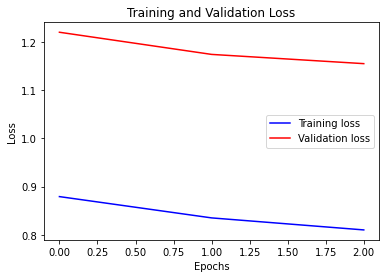

In [104]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

#Prediction
The trained model above is now able to make predictions for 5 sets of values from validation set.

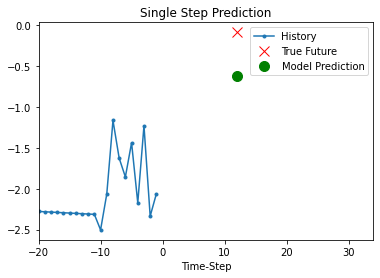

In [116]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(1):
    show_plot(
        [x[0][:, 4].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [118]:
dataset_val.take

<bound method DatasetV2.take of <BatchDataset shapes: ((None, None, 17), (None, 1)), types: (tf.float64, tf.float64)>>